In [360]:
%matplotlib inline

In [462]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from collections import OrderedDict

from matplotlib import pyplot as plt
from helpers import flatten

# comparing best metric value

for each method and metric (e.g, "ham") pair, take the best value over all returned entries

In [550]:
def show_opt_metric_values(graph):
    df1 = pd.read_pickle('outputs/{}_seed_pair_aug_k200.pkl'.format(graph))
    df1 = df1[df1['k']==200]
    df2 = pd.read_pickle('outputs/focg_{}_aug.pkl'.format(graph))
    
    d = OrderedDict()
    d['beta(our)'] = df1['beta'].min()
    d['beta(fo)'] = df2['beta'].min()
    
    d['ham(our)'] = df1['ham'].max()
    d['ham(fo)'] = df2['ham'].max()

    d['pc(our)'] = df1['pc'].max()
    d['pc(fo)'] = df2['pc'].max()

    return pd.DataFrame.from_dict([d])


In [551]:
graphs = ('word', 'bitcoin', 'ref', 'slashdot', 'epinions')
rows = []
for graph in graphs:
    df = show_opt_metric_values(graph)
    rows.append(flatten(df.values))

In [552]:
pd.DataFrame(np.asarray(rows), columns=df.columns, index=graphs)

,beta(our),beta(fo),ham(our),ham(fo),pc(our),pc(fo)
word,0.234649,0.725572,0.769733,1.000000,19.586777,11.000000
bitcoin,0.257143,0.538462,0.198014,0.017399,16.741722,2.148148
ref,0.694517,0.761878,0.231703,0.297227,45.898089,59.593846
slashdot,0.329032,0.614458,0.273343,0.288213,33.420000,6.879479
epinions,0.403670,0.167630,0.174299,0.235294,120.730000,8.277778


# querying nodes from good communities by FOCG

In [540]:
import random

from stat_helpers import *
from helpers import pos_adj, neg_adj
from core import query_graph_using_sparse_linear_solver, sweep_on_x_fast


def quick_stat(g, C1, C2):
    A = nx.adj_matrix(g, weight='sign')
    pos_A, neg_A = pos_adj(A), neg_adj(A)
    coh = cohe(pos_A, C1, C2)
    opp = oppo(neg_A, C1, C2)
    ham = 2 * coh * opp / (coh + opp)
    beta = sbr(pos_A - neg_A, C1, C2)
    print('ham {:.2f}'.format(ham))    
    print('beta {:.2f}'.format(beta))
    print('coh {:.2f}'.format(coh))
    print('opp {:.2f}'.format(opp))


    
def diff_sets(S1, S2):
    S1, S2 = map(set, (S1, S2))
    print('|S1|: ', len(S1))
    print('|S2|: ', len(S2))
    print('|S1 & S2|: ', len(S1.intersection(S2)))
    print('|S1 | S2|: ', len(S1 |S2))
    print('|S1 - S2|: ', len(S1 - S2))
    print('|S2 - S1|: ', len(S2 - S1))

In [544]:
def diff_graph(graph, idx=0):
    g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
    df = pd.read_pickle('outputs/focg_{}_aug.pkl'.format(graph))

    target_r = df.sort_values(by='ham', ascending=False).head(3).iloc[idx]
    target_r['C'] = list(target_r['C1']) + list(target_r['C2'])
    print(target_r[['ham', 'beta', 'opp', 'coh']])
    seed1 = random.choice(target_r['C1'])
    seed2 = random.choice(target_r['C2'])

    x, _ = query_graph_using_sparse_linear_solver(g, [[seed1], [seed2]], kappa=0.9, verbose=0, ub=g.graph['lambda1'])

    C1, C2, C, best_t, best_sbr, ts, sbr_list = sweep_on_x_fast(g, x, top_k=100)

    diff_sets(C, target_r['C'])
    quick_stat(g, C1, C2)
    from viz_helpers import draw_query_result
    draw_query_result(g, C1, C2)

ham            1
beta    0.725572
opp            1
coh            1
Name: 0, dtype: object
|S1|:  82
|S2|:  12
|S1 & S2|:  12
|S1 | S2|:  82
|S1 - S2|:  70
|S2 - S1|:  0
ham 0.08
beta 0.62
coh 0.05
opp 0.22


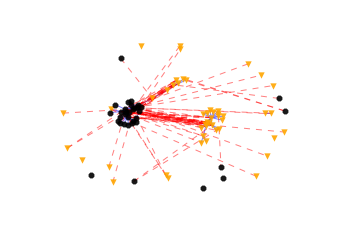

In [541]:
diff_graph('word')

ham     0.198582
beta    0.969178
opp     0.116667
coh     0.666667
Name: 5, dtype: object
|S1|:  62
|S2|:  16
|S1 & S2|:  2
|S1 | S2|:  76
|S1 - S2|:  60
|S2 - S1|:  14
ham 0.02
beta 0.90
coh 0.06
opp 0.01


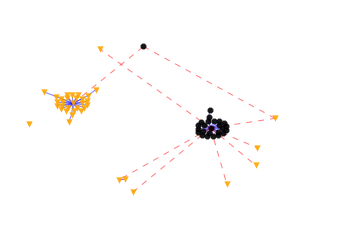

In [545]:
diff_graph('ref', idx=1)

ham     0.214414
beta    0.977949
opp     0.145833
coh     0.404762
Name: 6, dtype: object
|S1|:  75
|S2|:  20
|S1 & S2|:  2
|S1 | S2|:  93
|S1 - S2|:  73
|S2 - S1|:  18
ham 0.02
beta 0.84
coh 0.02
opp 0.02


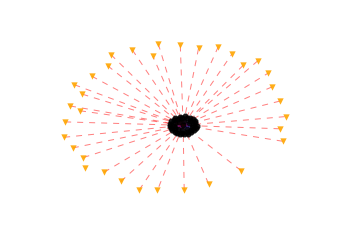

In [546]:
diff_graph('slashdot', idx=1)

ham     0.571429
beta    0.982823
opp            1
coh          0.4
Name: 5, dtype: object
|S1|:  64
|S2|:  19
|S1 & S2|:  2
|S1 | S2|:  81
|S1 - S2|:  62
|S2 - S1|:  17
ham 0.04
beta 0.89
coh 0.03
opp 0.07


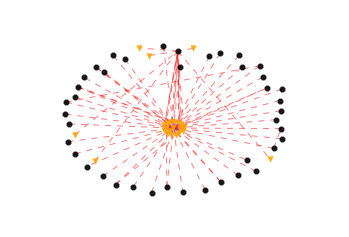

In [547]:
diff_graph('wikiconflict', idx=0)